# Tarea 6

Métodos Computacionales, 2015-19

Sebastián Camilo Puerto, 201318518

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Punto 1: Cálculo Simbólico

In [2]:
from sympy import *

init_printing(use_unicode = True)  # Para que utilice los caracteres de Unicode para renderizar bonito

### a)

In [3]:
def lagrange(n):
    
    var('t')  #t como símbolo, que utilizo tal como se renderiza
    
    # Definir los t's y f's para utilizar como símbolos
    for i in range(n):
        exec("t_" + str(i) + ", f_" + str(i) + " = symbols('t_{" + str(i) + "}, f_{" + str(i) + "}')")
    
    polinomio = Float(0)
    
    # Hacer polinomio
    for i in range(n):
        
        # Hacer monomios  
        termino = eval("f_" + str(i))
        for j in range(n):      
            if i != j:
                termino *= eval("(t - t_" + str(j) + ")/(t_" + str(i) + " - t_" + str(j) + ")")
        
        polinomio += termino
        
    return polinomio

### b)  
Adams-Bashford de orden $m$ para hallar el vector estado en $t_m$

NOTA: En el enunciado aparecen en orden contrario los coeficientes

In [4]:
def adams(m):
    
    # Hallar polinomio base
    polinomio = lagrange(m)
    
    # Definir los t's y f's para utilizar como símbolos
    for i in range(m):
        exec("t_" + str(i) + " = symbols('t_{" + str(i) + "}')")
        
    # Redefinir símbolos en terminos de t_{n-1} y h
    tn1, h = symbols('t_{n-1}, h')
    
    for i in range(0, m):
        polinomio = polinomio.subs(eval('t_' + str(m-1 - i)), tn1 - i*h)
    
    # Integrar para hallar la diferencia del vector estado para t_n
    return simplify(integrate(polinomio, (t, tn1, tn1 + h)))
    

## Punto 2: Ecuación de Poisson para el Potencial Gravitacional



In [208]:
# Unidades SI

G = 6.67384E-11                # 
L = 3000.
l = 270.

h = 30.
N = int(round((L + h) / h, 0) + .1)

rho = 400.
masa = rho * l**3

rhs = 4 * np.pi * G

# Límites del cubo que produce el campo gravitacinal
x_min = y_min = z_min = -L/2 
x_max = y_max = z_max =  L/2

# Ticks de los ejes, centrados en los cuadros que componen la cuadrícula
## que discretiza el espacio representado (un cubo de L metros de largo)
# Hago una cuadrícula
#x_tick = np.linspace(x_min + h/2., x_max - h/2., N)
#y_tick = np.linspace(y_min + h/2., y_max - h/2., N)
#z_tick = np.linspace(z_min + h/2., z_max - h/2., N)
x_tick = np.linspace(x_min, x_max, N)
y_tick = np.linspace(y_min, y_max, N)
z_tick = np.linspace(z_min, z_max, N)


## Particular para este tipo de casos, para que el sólido interno ocupe
### casillas exactas que le corresponden. Me atrevo a hacerlo porque
### parece que se asume que así es en el siguiente punto.
### Corresponde a un pequeño 
### corrimiento de las coordenadas, cambiandose un poco los límites del
### espacio. Procuro no hacer uso de esto en el resto de este punto (2a)
### ya que preferiría aumentar o disminuir en h metros los líms del espacio,
### para lo cual sólo habría que eliminar los pedazos de h/2 que puse
### en la definición de los ticks, pero me atengo a mantener el largo
### del espacio como aparece en el enunciado explícitamente.
#x_tick -= h/2.
#y_tick -= h/2.
#z_tick -= h/2.

## En este caso, el origen está justo donde indica este índice
i_ctro = int(round(N / 2, 0) + .1)

# Meshgrid para las coordenadas del espacio.
# La forma en que lo escribí permite cambiar a un paralelepípedo sin
## dolores de cabeza (por alguna razón no es intuitivo el meshgrid).
y_mesh, x_mesh, z_mesh = np.meshgrid(y_tick, x_tick, z_tick) # Sólo así me funcionó

# Potencial (phi) de masa puntual centrada como ansatz
## Como numpy soporta -inf y estoy tratando con ndarrays, no me preocupo
### por la división en 0 que surge 
phi = (-G * masa / np.sqrt(x_mesh**2 + y_mesh**2 + z_mesh**2))# + 1.E-10))
phi[i_ctro, i_ctro, i_ctro] = phi[i_ctro, i_ctro, i_ctro + 1]

phi[0] = 0.
phi[-1] = 0.
phi[:, 0, :] = 0.
phi[:, -1, :] = 0.
phi[:, :, 0] = 0.
phi[:, :, -1] = 0.

# Distribución de densidad de la masa que genear el campo gravitacional.
## Cubo de lado l, centrado en el origen
densidad = np.ones((N, N, N)) * rho
densidad[np.abs(x_mesh) > l/2.] *= 0
densidad[abs(y_mesh) > l/2.] *= 0
densidad[abs(z_mesh) > l/2.] *= 0

(101, 101, 101)


/home/cohnan/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:55: RuntimeWarning: divide by zero encountered in divide


In [209]:
# Resolución de la ecuación

iteraciones = 3000

for i in range(iteraciones):
    phi = (- rhs * densidad * h**2 + 
           np.roll(phi, 1, axis = 0) + np.roll(phi, -1, axis = 0) + # x
           np.roll(phi, 1, axis = 1) + np.roll(phi, -1, axis = 1) + # y
           np.roll(phi, 1, axis = 2) + np.roll(phi, -1, axis = 2)   # z
          ) / 6.
    
    # Condiciones de frontera
    phi[0] = 0.
    phi[-1] = 0.
    phi[:, 0, :] = 0.
    phi[:, -1, :] = 0.
    phi[:, :, 0] = 0.
    phi[:, :, -1] = 0.

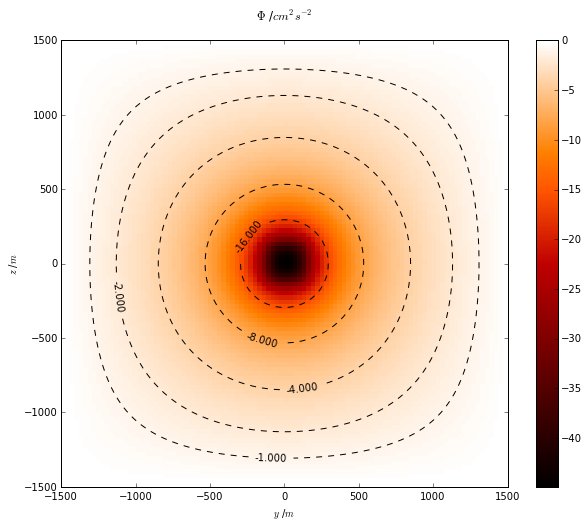

In [218]:
fig_1 = plt.figure('Potencial Gravitacional', figsize=(10,8))
ax_11 = fig_1.add_subplot(111)

ax_11.set_title('$\Phi$ /$cm^{2}s^{-2}$\n')
ax_11.set_xlabel('$y$ /$m$')
ax_11.set_ylabel('$z$ /$m$')

fig_1.colorbar(ax_11.pcolor(y_tick, z_tick, 100**2 * phi[i_ctro], cmap='gist_heat'))
ax_11.clabel(ax_11.contour(y_tick, z_tick, 100**2 * phi[i_ctro], levels=[-1, -2, -4, -8, -16],colors = 'k'))

ax_11.set_xlim([-1500, 1500])
ax_11.set_ylim([-1500, 1500])

plt.show()

### c)

In [223]:
phi_2 = np.zeros((N, N, N))
#suma = 0
for i in range(-4, 5):
    for j in range(-4, 5):
        for k in range(-4, 5):
            #suma += densidad[i_ctro + i, i_ctro + j, i_ctro + k]
            phi_2 += - G * (h**3 * rho
                           ) / np.sqrt((x_mesh - i*h)**2 + (y_mesh - j*h)**2 + (z_mesh - k*h)**2)
            phi_2[i_ctro + i, i_ctro + j, i_ctro + k] = phi_2[i_ctro + i, i_ctro + j, i_ctro + k + 1]
            
#print suma / 400

/home/cohnan/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


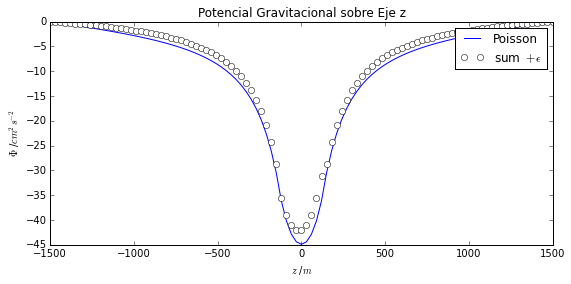

In [243]:
fig_2 = plt.figure(u'Comparación Potencial', figsize=(9, 4))
ax_21 = fig_2.add_subplot(111)

ax_21.set_title('Potencial Gravitacional sobre Eje z')
ax_21.set_xlabel('$z$ /$m$')
ax_21.set_ylabel('$\Phi$ /$cm^{2}s^{-2}$')

ax_21.plot(z_tick, 100**2 * phi  [i_ctro, i_ctro], label = "Poisson")
ax_21.plot(z_tick, 100**2 * (phi_2[i_ctro, i_ctro] - phi_2[i_ctro, i_ctro, 0]),
           'wo', label='sum $+\epsilon$') # Constante tal que en los extremos sea 0

ax_21.legend()
plt.show()

### c)

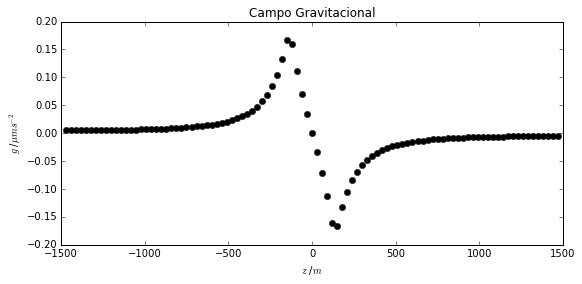

In [258]:
potencial_z = 100**2 * phi[i_ctro, i_ctro]

derivadas = (np.roll(potencial_z, 1) - np.roll(potencial_z, -1)
           ) / (2 * h)
fig_3 = plt.figure('Campo Gravitacional', figsize=(9,4))
ax_31 = fig_3.add_subplot(111)

ax_31.set_title('Campo Gravitacional')
ax_31.set_xlabel('$z$ /$m$')
ax_31.set_ylabel('$g$ /$\mu m s^{-2}$')

ax_31.plot(z_tick[1:-1], derivadas[1 : -1], 'ko')

ax_31.legend()
plt.show( )

### d)

In [286]:
from scipy import interpolate

# SI units
timestep = 0.2 #s
dif_dist = 0.1 #m
Y_0 = array([l/2. + 500., 0.]) # Sólo en z, cara superior

campo_grav_z = interpolate.interp1d(z_tick[1:-1], derivadas[1:-1] / 100**2)

def fun_der(Y, t):  
    return array([Y[1], campo_grav_z(Y[0])])

def runge_kutta_4th(fun_der, Y, t, timestep):

    k1 = fun_der(Y, t)
    k2 = fun_der(Y + timestep * k1 / 2., t + timestep / 2.)
    k3 = fun_der(Y + timestep * k2 / 2., t + timestep / 2.)
    k4 = fun_der(Y + timestep * k3, t + timestep)
    
    return Y + timestep*(k1/6. + k2/3. + k3/3. + k4/6.)

Ys = [Y_0]
Y_act = Ys[0]
t = 0.

while Y_act[0] > l/2.:
    Y_act = runge_kutta_4th(fun_der, Y_act, t, timestep)
    Ys.append(Y_act)
    t += timestep

horas = t // 3600 
minutos = (t - 3600 * horas) // 60
segundos = t - 3600 * horas - 60 * minutos

print "Tiempo:", horas, ":", minutos, ":", round(segundos, 0)

Tiempo: 6.0 : 21.0 : 10.0


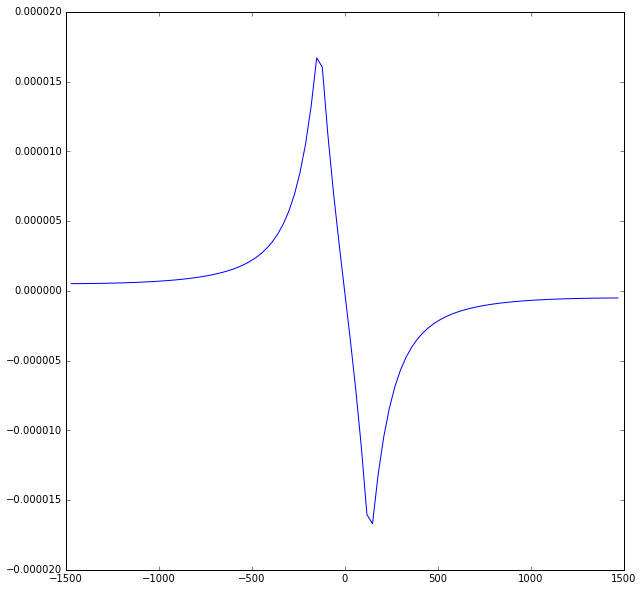

In [38]:
x_t = np.linspace(-1, 1, 3)
y_t = np.linspace(-6, 6, 5)
z_t = np.linspace(-66, 66, 7)
print x_t
print y_t
print z_t
ym, xm, zm = np.meshgrid(y_t, x_t, z_t)

print
print 'dens1'

dens1 = np.zeros((3, 5, 7))
dens1[xm > 0 ] = 1

print dens1

print
print 'dens2'

dens2 = np.zeros((3, 5, 7))
dens2[ym > 3] = 1

print dens2

print
print 'dens3'

dens3 = np.zeros((3, 5, 7))
dens3[zm > 15] = 1

print dens3

print
print 'dens4'

dens4 = np.zeros((3, 5, 7))
dens4[ym > 3] = 1
dens4[abs(zm) <= 22] = 1

print dens4

[-1.  0.  1.]
[-6. -3.  0.  3.  6.]
[-66. -44. -22.   0.  22.  44.  66.]

dens1
[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.]]]

dens2
[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0. 